## Exploratory Analysis of Spatial Data


### What is GIS
A geographic information system (GIS) is a framework for gathering, managing and analysing data. Rooted in the science of geography, GIS integrates many types of data. It analyses spatial location and organises layers of information into visualisations using maps and 3D scenes. 

GIS refers to a collection of various components:
<img src="GIS_data/fig_20.png" alt="maps" width="250"/> 
**Maps**: Maps are the geographic container for the data layers and analytics you want to work with.
<img src="GIS_data/fig_21.png" alt="data" width="250"/> 
**Data**: GIS integrates many different kinds of data layers using spatial location. Most data has a geographic component. GIS data includes imagery, features and basemaps linked to spreadsheets and tables.
<img src="GIS_data/fig_22.png" alt="analysis" width="250"/> 
**Analysis**: Spatial analysis lets you evaluate suitability and capability, estimate and predict, interpret and understand and much more, lending new perspectives to your insight and decision-making.
<img src="GIS_data/fig_23.png" alt="apps" width="250"/> 
**Apps**: Apps provide focused user experiences for getting work done and bringing GIS to life for everyone.

### Point, Line, Polygon, Multi-Polygon

Let's mathematise our world!

<img src="GIS_data/fig_10.png" alt="doge" width="500"/> 

We can transform the objects on these layers and represent them in a mathematical way  
Example: Assessing the impact of a natural catastrophe
<img src="GIS_data/fig_11.png" alt="doge" width="600"/> 

<img src="GIS_data/fig_12.png" alt="doge" width="470"/> 

__Polygon vs. Multi-Polygon__  
A Polygon is a planar Surface defined by 1 exterior boundary and 0 or more interior boundaries. Each interior boundary defines a hole in the Polygon.

<img src="GIS_data/fig_polygon.png" alt="doge" width="470"/> 

A MultiPolygon is a MultiSurface whose elements are Polygons.
<img src="GIS_data/fig_mpolygon.png" alt="doge" width="530"/> 

### GIS and COVID-19
In the fight against COVID-19, Geographic Information Systems (GIS) and big data technologies have played an important role in many aspects, including 
- rapid aggregation of multi-source big data, 
- rapid visualisation of epidemic information, 
- spatial tracking of confirmed cases, 
- prediction of regional transmission, 
- spatial segmentation of the epidemic risk and prevention level, 
- and balancing and management of the supply and demand of material resources, 

which provided solid spatial information support for decision-making, measures formulation, and effectiveness assessment of COVID-19 prevention and control. 

## What are we solving today?
<b>Question: If you were tasked to open the next Covid-19 Test Sites, which region would you prioritise? </b>

### Python packages for Spatial Analysis
__GeoPandas__:  
The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.

__PySAL__:  
A library of spatial analysis functions. It consists of several layers, such as the ```lib```, ```explore```, ```model```, ```viz```  


__MapClassify__:  
Classification Schemes for Choropleth Maps. Its focus is on the determination of the number of classes, and the assignment of observations to those classes. It is intended for use with upstream mapping and geovisualization packages (see geopandas and geoplot) that handle the rendering of the maps

In [ ]:
import re
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import date, datetime
from more_itertools import take
from math import radians
from collections import Counter
tqdm.pandas()

import geopandas as gpd
import mapclassify as mc
import libpysal as lps
import esda 
from shapely.geometry import Point

matplotlib.rcParams['figure.figsize'] = (6.0, 3.6)

### Load raw data
**Disclaimer**:  
The data we use is dummy data mimicking the Covid-19 test sites data. The insights we draw from the data by no mean reflect the reality or intended for public. The purpose of this notebook is to demo some GIS-related Python packages and to showcase the type of analysis we can do.  

Please take the result of the analysis with a pinch of salt.

In [ ]:
raw_df = pd.read_csv('/your/data.csv')
raw_df.head()

Expected layout of your dataframe, where subject longitude and latitude indicate the test subject's location whereas the test longitude and test latitude indicate the test site's location

| subject_longitude |	subject_latitude |	test_longitude	| test_latitude |
|-----|------|-------|-------|
|-4.807622  |55.648735	|-4.610511	|55.509274|
|-4.258670	|55.834060	|-3.964009	|55.792134|
|-4.166302	|55.848796	|-4.432246	|55.864572|
|-3.223956	|55.833043	|-3.359951	|55.946288|
|-3.661014	|55.898395	|-3.620187	|55.874626|

## Prepare an attribute as the proxy for test site availability
In this case, we use subject's median travel distance to site as a proxy


<img src="GIS_data/warning_1.jpg" alt="warning" width="250"/> 
<br>
<center><b>Don't Panic! Skim If You Have To!</b></center>

### Calculate Distance

__Warming up__  
Reminder of some school maths...    
<br>
<img src="GIS_data/Circle.png" alt="warning" width="150"/> 
The circumference of a circle is defined by  
<center> $C = 2\pi r$ </center> 
<br>
from this we can derive  
<center> $2\pi = \frac{C}{r}$ </center>  
<br>
In polar coordinate system (conversion between radian and degree)  
<center> $2\pi$ = 360&deg; </center> 

<img src="GIS_data/central_angle.png" alt="warning" width="150"/> 
<br>
Hence, we can calculate the arc length given the central angle and radius  
<br>
<center> $d = \theta r$ </center> 

The **haversine formula** determines the great-circle distance between two points on a sphere given their longitudes and latitudes. 


<img src="GIS_data/fig_9.jpg" alt="doge" width="150"/> 

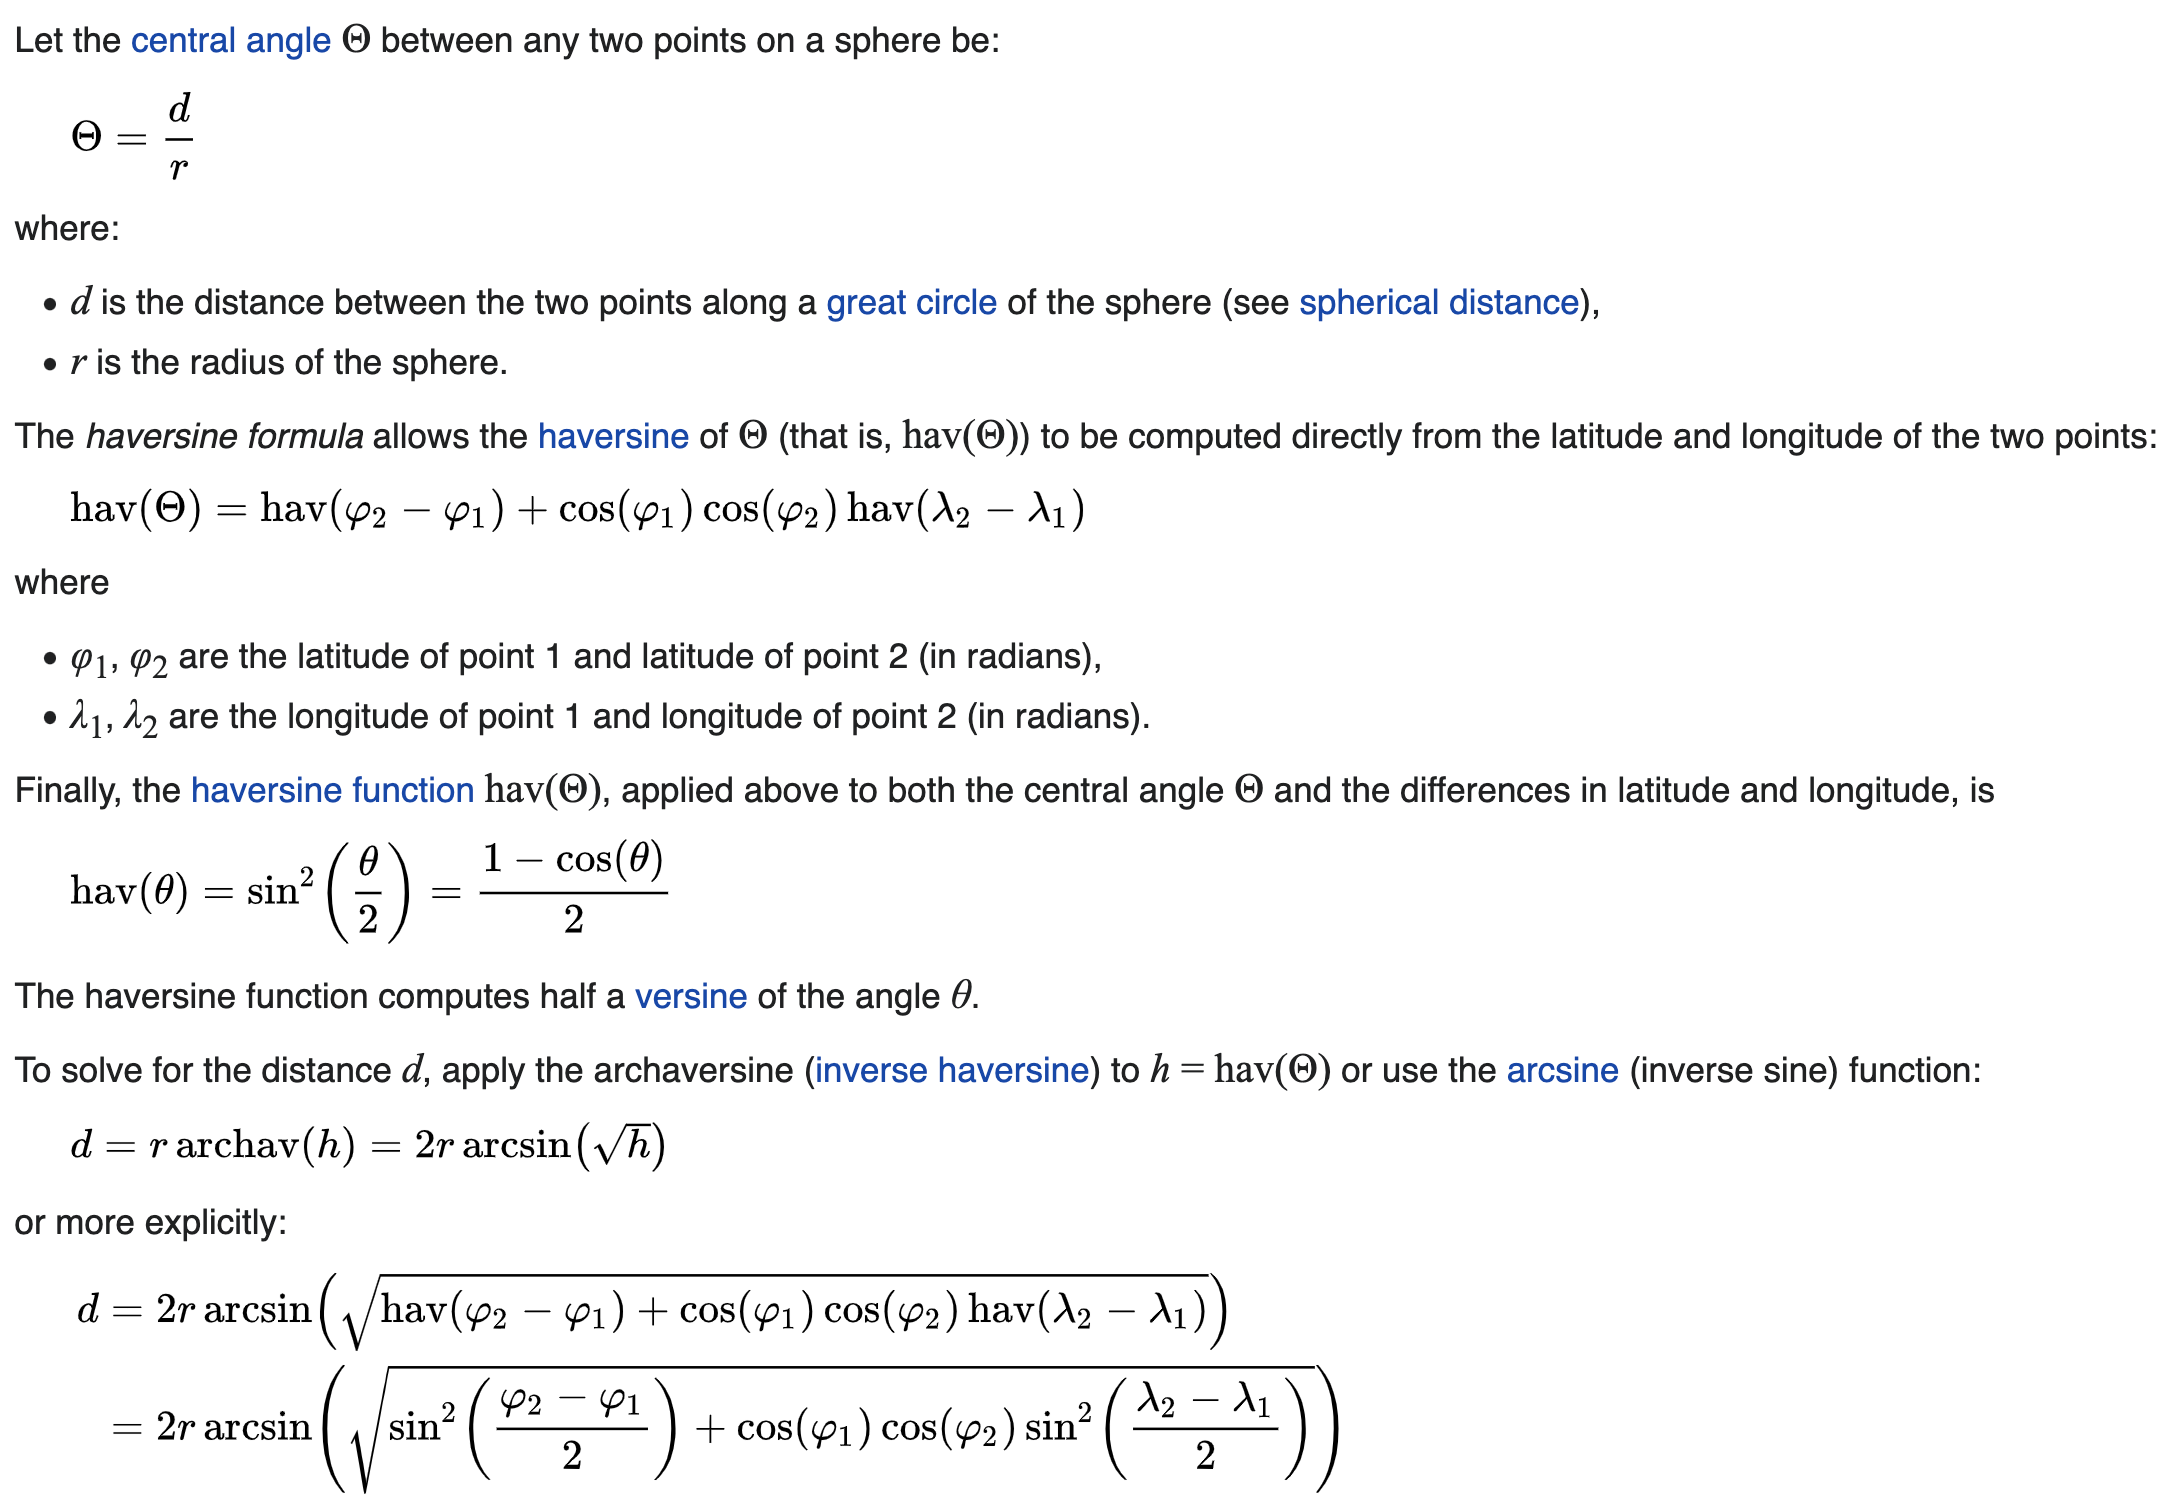


<br>
Writing in Python

In [ ]:
def haversine_np(lon1, lat1, lon2, lat2, unit='mile'):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees) in miles.

    All args must be of equal length.    
    :param unit: whether to return distances in miles or kilometres
    :type unit: str, ["mi", "mile", "km", "kilometre"]
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    if unit in ['mi', 'mile']:
        dist = 3958.8 * c
    elif unit in ['km','kilometre']:
        dist = 6371 * c
    return dist

In [ ]:
raw_df['Distance'] = raw_df.apply(lambda r: haversine_np(r.test_longitude,
                                                        r.test_latitude,
                                                        r.subject_longitude,
                                                        r.subject_latitude,
                                                        unit='km'), axis=1)

### Working with GeoPandas
#### Transform Pandas dataframe to GeoPandas dataframe

A GeoDataFrame needs a shapely object. We use geopandas points_from_xy( ) to transform Longitude and Latitude into a list of shapely.Point objects and set it as a geometry while creating the GeoDataFrame.   
(note that points_from_xy( ) is an enhanced wrapper for [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)])

In [ ]:
gdf = gpd.GeoDataFrame(
    raw_df[['subject_longitude','subject_latitude',
             'test_longitude', 'test_latitude', 'Distance']]
    , geometry=gpd.points_from_xy(raw_df['test_longitude'], raw_df['test_latitude']))

In [ ]:
# A new column called 'geometry' will be created
gdf.head()

In [ ]:
test_sites_uk = gdf.drop_duplicates(subset=['test_longitude',
                                            'test_latitude'])
test_sites_uk.info()

#### Plot Points on a plane

In [ ]:
test_sites_uk.plot(figsize=(10,20))


#### Plot Points on the UK map

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [ ]:
# then restrict this to the United Kingdom
ax = world[(world.name == "United Kingdom")].plot(
        color='white', edgecolor='black')

ax.figure.set_size_inches(10,20)

# We can now plot our ``GeoDataFrame``.
test_sites_uk.plot(ax=ax, color='brown')
plt.show()

#### Plot Polygons and show more granular level

UK boundary data split by local authority (LA)  
UK-GeoJSON:
https://martinjc.github.io/UK-GeoJSON/   
Download and import the relevant JSON which contains LA boundaries spatial data

In [ ]:
eng_la = gpd.read_file('path_to/england_local_authority_boundaries.json')
scot_la = gpd.read_file('path_to/scotland_local_authority_boundaries.json')
wales_la = gpd.read_file('path_to/wales_local_authority_boundaries.json')
ni_la = gpd.read_file('path_to/northern_ireland_local_authority_boundaries.json')

ni_la.rename(columns={'LGDNAME': 'LAD13NM',
                      'LGDCode': 'LAD13CD',
                      'OBJECTID': 'LAD13CDO',
                      'AREA': 'LAD13NMW'
                     }, inplace=True)
ni_la = ni_la[['id','LAD13CD','LAD13CDO','LAD13NM','LAD13NMW','geometry']]

uk_la = pd.concat([eng_la, scot_la, wales_la, ni_la])
print(eng_la.shape)
print(scot_la.shape)
print(wales_la.shape)
print(ni_la.shape)
print(uk_la.shape)

In [ ]:
uk_la.tail()

__geopandas.sjoin()__  
Spatial join of two GeoDataFrames.

In [ ]:
# Spatial object in test_sites_uk
test_sites_uk.geometry.head()

In [ ]:
# Spatial object in uk_la
uk_la.geometry.head()

In [ ]:
# Joining on intersection
sj_gdf = gpd.sjoin(uk_la, test_sites_uk, how='inner', op='intersects', lsuffix='left', rsuffix='right')
sj_gdf.head()

#### Median travel distance by local authority
Join median travel distances back to the UK map  

**geometry** in **uk_la** is MULTIPOLYGON / POLYGON  
**geometry** in **test_sites_uk** is POINT

In [ ]:
median_distance_gb = sj_gdf[['LAD13CD','LAD13NM','Distance']].groupby(['LAD13CD','LAD13NM']).median().reset_index()
median_distance_gb.rename(columns={'Distance': 'median_distance'}, inplace=True)


In [ ]:
uk_la = pd.merge(uk_la, median_distance_gb, how='left', on=['LAD13CD','LAD13NM'])
uk_la.head()

Deal with Null values

In [ ]:
uk_la['median_distance'].fillna((uk_la['median_distance'].mean()), inplace=True)

Plot median travel distances on a UK map

In [ ]:
fig, ax = plt.subplots(figsize=(10, 20), subplot_kw={'aspect':'equal'})
uk_la.plot(column='median_distance', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)
plt.title('Median travel distance by local authority')

#### "Case closed? "  

Visual inspection of the map pattern for the travel distances allows us to search for spatial structure. If the spatial distribution of the travel distances was random, then we should not see any clustering of similar values on the map. However, our visual system is drawn to the darker clusters in the south west as well as the north, and a concentration of the lighter hues (shorter travel distances) in the central and south east.  

Our brains are very powerful pattern recognition machines. However, sometimes they can be too powerful and lead us to detect false positives, or patterns where there are no statistical patterns. This is a particular concern when dealing with visualisation of irregular polygons of differning sizes and shapes.  

An example is the Highland - a large local authority that takes up a good proportion of the UK map.

### Spatial Autocorrelation

Let's start with a quote: Tobler’s First Law of Geography  
-- __"Everything is related to everything else. But near things are more related than distant things."__

The concept of spatial autocorrelation relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of simmilarity into a summary measure.



#### Type 1: Spatial Similarity
In spatial autocorrelation analysis, the spatial weights are used to formalise the notion of spatial similarity.


__---> Defining Neighbourhoods__  
Again, let's start simple...

<img src="GIS_data/rookmove.png" alt="rook" width="200"/>
<img src="GIS_data/queenmov.gif" alt="queen" width="200"/>

<img src="GIS_data/fig_13.png" alt="contiguity_type" width="600"/>
<img src="GIS_data/fig_14.png" alt="contiguity_type" width="600"/>
<img src="GIS_data/fig_15.png" alt="contiguity_type" width="600"/>
<img src="GIS_data/fig_16.png" alt="contiguity_type" width="600"/>


Two most common ways of defining neighboors in GIS are:  
*Rook* neighbours are those local authorities that share an edge on their respective borders  
*Queen* neighbours are based on a more inclusive condition that requires only a shared vertex between two local authorities  

<img src="GIS_data/fig_1.png" alt="contiguity_type" width="650"/>

  
Let's use PySAL to generate the first type of similarity measures.
```python
import libpysal as lps
```

1. **Spatial Similarity**


In [ ]:
df = uk_la.copy()
wq = lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

weights transformation,  default is row-standardized "r". Other options include   
                      "B": binary,    
                      "D": doubly-standardized,    
                      "U": untransformed (general weights),  
                      "V": variance-stabilizing.

In [ ]:
# See what spatial weights look like
take(7, wq.weights.items())

In [ ]:
take(7, wq.neighbors.items())

What it means: Local authorty (ID:1) take 1/3 effect from each of its 3 neighbours ID:186, ID:2, ID:3.

Visualising the connection between neighbours (on the UK map)

In [ ]:
ax = uk_la.plot(edgecolor='grey', facecolor='w', figsize=(10,20))
f,ax = wq.plot(uk_la, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

#### Type 2: Attribute Similarity
So the spatial weight between neighborhoods i and j indicates if the two are neighbors (i.e., geographically similar). What we also need is a measure of attribute similarity to pair up with this concept of spatial similarity. The spatial lag is a derived variable that accomplishes this for us. For neighborhood i the spatial lag is defined as:

$ ylag_i = \sum_{j=1}^{n} w_{ij} y_j $

Here, our attribute is median travel distances.

  
Let's use PySAL to generate the second type of similarity measures.

2. **Attribute Similarity**

In [ ]:
attribute = 'median_distance'
y = df[attribute]
ylag = lps.weights.lag_spatial(wq, y)
print(f"The output returns {len(ylag)} spatial lags")

In [ ]:
ylag[:7]

Let's use MapClassify to apply a classification: quantile
```python
import mapclassify as mc
```


In [ ]:
ylag_q5 = mc.Quantiles(ylag, k=5)
ylag_q5

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 20))
df.assign(cl=ylag_q5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Distance (Quantiles)")

plt.show()


In [ ]:
lag_attribute = 'lag_' + attribute
lag_attribute

Bring together two graphs (Before autocorrelation vs. After autocorrelation)

In [ ]:
df[lag_attribute] = ylag
f,ax = plt.subplots(1,2,figsize=(40,20))
df.plot(column=attribute, ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Travel Distances")
df.plot(column=lag_attribute, ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Travel Distances")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

The quantile map for the spatial lag tends to enhance the impression of value similarity in space. It is, in effect, a local smoother.
<br>
<br>

Like this, if you will...
<br>
<br>
<br>

<img src="GIS_data/fig_6.jpg" alt="median_uk_plot" width="780"/> 

Or this...
<br>
<img src="GIS_data/fig_7.jpg" alt="median_uk_plot" width="780"/> 

### Global Spatial Autocorrelation  
The global spatial autocorrelation is designed to reject the null hypothesis of spatial randomness in favor of an alternative of clustering. Such clustering is a characteristic of the complete spatial pattern and does not provide an indication of the location of the clusters.  

Hypothesis:  
$H_0$ = The pattern we saw on the map was random;  
$H_1$ = The pattern we saw on the map was NOT random (i.e. there were some genuine clusters);  

<img src="GIS_data/fig_17.jpg" alt="median_uk_plot" width="180"/> 

In [ ]:
# Median of our attributes 

print(f"Median of LA medians: {df[attribute].median()}")
print(f"Median of entire dataset: {test_sites_uk.Distance.median()}")
global_dist = df.median_distance.median()

In [ ]:
binary = df[attribute] > global_dist
print(f"We have {sum(binary)} neighborhoods(LA) with median distances above the global median")

In [ ]:
labels = ["0 Low", "1 High"]
binary = [labels[i] for i in 1*binary] 
df['binary'] = binary

Colour the UK map with Black(higher than median) and White(lower than median)

In [ ]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='binary', cmap='binary', edgecolor='grey', legend=True, ax=ax)

#### Join counts
One way to formalise a test for spatial autocorrelation in a binary attribute is to consider the so-called joins. A join exists for each neighbour pair of observations, and the joins are reflected in our binary spatial weights object wq.  
<br>
Each unit can take on one of two values "Black" or "White", and so for a given pair of neighbouring locations there are three different types of joins that can arise:  
<br>
Black Black (BB)  
White White (WW)  
Black White (or White Black) (BW)  
<br>
Given that we have the number of Black polygons we saw on our map, what is the number of Black Black (BB) joins we could expect if the process were such that the Black polygons were **randomly assigned** on the map? This is the logic of join count statistics.  

We can use the ```esda``` package from PySAL to carry out join count analysis:

In [ ]:
# convert back to binary
binary = 1 * (df[attribute] > global_dist) 
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(42)
jc = esda.join_counts.Join_Counts(binary, wq)

The resulting object stores the observed counts for the different types of joins:

In [ ]:
# Black Black (BB)
jc.bb

In [ ]:
# White White (WW)
jc.ww

In [ ]:
# Black White (BW, WB)
jc.bw

Note that the three cases exhaust all possibilities

In [ ]:
jc.bb + jc.ww + jc.bw

__Simulating a randomly assignment__  
The critical question for us, is whether this is a departure from what we would expect if the process generating the spatial distribution of the Black polygons were a completely random one? To answer this, PySAL uses random spatial permutations of the observed attribute values to generate a realisation under the null of complete spatial randomness (CSR). This is repeated a large number of times (999 default) to construct a reference distribution to evaluate the statistical significance of our observed counts.  


In [ ]:
len(jc.sim_bb)

In [ ]:
jc.sim_bb[:9]

In [ ]:
jc.mean_bb

In [ ]:
jc.mean_bw

A kernel density estimate (KDE) plot is a method for visualising the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.

In [ ]:
sns.kdeplot(jc.sim_bb.astype('float'), shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

The density portrays the distribution of the BB counts, with the black vertical line indicating the mean BB count from the synthetic realisations and the red line the observed BB count for our selected attribute. Clearly our observed value is extremely high.  

**p-value**: the probability of obtaining test results at least as extreme as the results actually observed   
  
And our p-value summarised this:

In [ ]:
jc.p_sim_bb

Hypothesis:  
$H_0$ = The pattern we saw on the map was random;  
$H_1$ = The pattern we saw on the map was NOT random;  
  
__Conclusion__:  
Reject null hypothesis

### Local Autocorrelation: Hot Spot, Cold Spot and Spatial Outliers
In addition to the Global autocorrelation statistics, PySAL has many local autocorrelation statistics.    
  
**Recap**:  
Global spatial correlation is searching for clustering as a characteristic of the complete spatial pattern and does not provide an indication of the location of the clusters.  

The concept of a local indicator of spatial association (LISA) is therefore suggested to remedy this situation. A LISA is seen as having two important characteristics. First, it provides a statistic for each location with an assessment of significance. Second, it establishes a proportional relationship between the sum of the local statistics and a corresponding global statistic.  



__Local Moran Statistic__  
A way to identify local clusters and local spatial outliers.   
  
With row-standardised weights, the sum of all weights,  
<center> $ \sum_{i} \sum_{j} w_{ij} $ </center>  

Let $z$ be deviations from the mean,  
<br>
Moran’s I statistics is:  
<center> $ I = \frac{\sum_{i} \sum_{j} w_{ij}z_{i}z_{j}}{\sum_{i} z_{i}^2} $  
</center> 
For each individual local authority will be:   
<center> 
$ I_{i} = \frac{\sum_{j} w_{ij}z_{i}z_{j}}{\sum_{i} z_{i}^2} $  



</center> 
 
<br>

Again, we can leverage the `esda` package from PySAL

In [ ]:
attribute = 'median_distance'

y = df[attribute]

wq.transform = 'r'
ylag = lps.weights.lag_spatial(wq, y)

In [ ]:
# Least squares polynomial fit
b, a = np.polyfit(y, ylag, 1)
f, ax = plt.subplots(1, figsize=(13, 7))

plt.plot(y, ylag, '.', color='firebrick')

# Each LA has a median distance
# dashed vert at mean of the median distances
plt.vlines(y.mean(), ylag.min(), ylag.max(), linestyle='--')
# dashed horizontal at mean of lagged median distances 
plt.hlines(ylag.mean(), y.min(), y.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(y, a + b*y, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Distance')
plt.xlabel('Median Travel Distance')
plt.show()


In [ ]:
li = esda.moran.Moran_Local(y, wq, transformation = "r", permutations = 99)

Count number of data points fell into each of the 4 quadrants

In [ ]:
Counter(li.q)

Attribute **p_sim**: (if permutations>0) p-values based on permutations (one-sided) null: spatial randomness alternative: the observed Ii is further away or extreme from the median of simulated values. It is either extremely high or extremely low in the distribution of simulated Is.



In [ ]:
(li.p_sim < 0.05).sum()

We can distinguish the specific type of local spatial association reflected in the four quadrants of the Moran Scatterplot above

<img src="GIS_data/fig_quadrant.png" alt="quad" width="300"/> 

Plot hot spots, cold spots, doughnuts and diamonds

In [ ]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2) # Surrounded by neighbours with hihger values
diamond = 4 * (sig * li.q==4) # Hihger value than neighbours
spots = hotspot + coldspot + doughnut + diamond

In [ ]:
spot_labels = ['0 not sig', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

In [ ]:
hmap = colors.ListedColormap(['lightgrey', 'crimson', 'lightblue', 'blue', 'coral'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

### What have we come to so far?
Comparing 3 graphs that we have plotted:
- Before applying spatial autocorrelation
- After applying spatial autocorrelation
- Hot spots, cold spots and outliers

In [ ]:
f,ax = plt.subplots(1,3,figsize=(40,20))
df.plot(column=attribute, ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
df.plot(column=lag_attribute, ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax[2], \
        edgecolor='white', legend=True)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

## Reference
https://www.esriuk.com/en-gb/what-is-gis/overview#image1  
Distance calculation: https://en.wikipedia.org/wiki/Haversine_formula#:~:text=The%20haversine%20formula%20determines%20the,and%20angles%20of%20spherical%20triangles.   
PySAL tutorial: https://pysal.org/libpysal/tutorial.html   
Spatial weights: (https://storymaps.arcgis.com/stories/5b26f25bb81a437b89003423505e2f71)
(https://geographicdata.science/book/notebooks/04_spatial_weights.html)
